In [16]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
SEED = 27

In [4]:
drop_cols = ["Patid", "status", "ratio_last", "ratio_max", "ratio_min", "ratio_mean", "Gdr_Cd"]
np.random.seed(SEED)

In [10]:
def make_logistic_classifier(features):
    # convert gender to a binary variable
    features["is_fem"] = (features["Gdr_Cd"] =="b'F'").astype(int)
    features = shuffle(features)
    y = features["status"].to_numpy()
    X = features.drop(columns=drop_cols)
    categorical = ["Diabetes", "is_fem"]
    # select columns for standard normalization
    to_normalize = [e for e in X.columns if e not in categorical]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

    ct = ColumnTransformer(transformers=[("norm", StandardScaler(), to_normalize),],
                      remainder="passthrough")
    clf = make_pipeline(ct, LogisticRegressionCV(random_state=SEED, max_iter=300))
    return clf, X_train, y_train, X_test, y_test

## I. ALD Prediction

In [11]:
ald = pd.read_csv("/nfs/turbo/lsa-regier/OPTUM2/ald_features.csv")
clf, X_train, y_train, X_test, y_test = make_logistic_classifier(ald)

In [19]:
ald["status"].value_counts()

0    33141
1    32941
Name: status, dtype: int64

In [12]:
clf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('norm', StandardScaler(),
                                                  ['Yrdob', 'n_obs', 'alt_last',
                                                   'alt_max', 'alt_min',
                                                   'alt_mean', 'ast_last',
                                                   'ast_max', 'ast_min',
                                                   'ast_mean', 'plt_last',
                                                   'plt_max', 'plt_min',
                                                   'plt_mean', 'long_history',
                                                   'latest_age'])])),
                ('logisticregressioncv',
                 LogisticRegressionCV(max_iter=300, random_state=27))])

In [13]:
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.7736120306440935, 0.7770295831126579)

In [14]:
y_hat = clf.predict_proba(X_test)
auroc = roc_auc_score(y_test, y_hat[:, 1])
print(auroc)

0.8521941509703226


In [17]:
cm = confusion_matrix(y_test, (y_hat[:, 1] > .5).astype(int), normalize=None)
print(cm)

[[5620 1044]
 [1903 4650]]


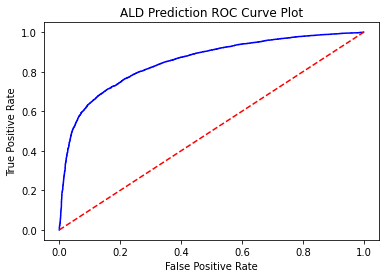

In [18]:
fpr, tpr, _ = roc_curve(y_test, y_hat[:, 1])
plt.plot(fpr, tpr, 'b', label="roc curve")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ALD Prediction ROC Curve Plot")
plt.show()

## II. NALD Prediction

In [9]:
nald = pd.read_csv("/nfs/turbo/lsa-regier/OPTUM2/nald_features.csv")
# extract healthy/cases only
nald = nald[nald["status"].isin((0, 1))]
# convert gender to binary variable
nald["is_fem"] = (nald["Gdr_Cd"] =="b'F'").astype(int)
nald = shuffle(nald)
y = nald["status"].to_numpy()
X = nald.drop(columns=drop_cols)

In [39]:
categorical = ["Diabetes", "is_fem"]
to_normalize = [e for e in X.columns if e not in categorical]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

ct = ColumnTransformer(transformers=[("norm", StandardScaler(), to_normalize),],
                      remainder="passthrough")
clf = make_pipeline(ct, LogisticRegressionCV(random_state=SEED, max_iter=300))

In [40]:
clf.fit(X_train, y_train)

/home/pchatha/.cache/pypoetry/virtualenvs/tfmdoc-uxlquJcz-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/pchatha/.cache/pypoetry/virtualenvs/tfmdoc-uxlquJcz-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver op

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('norm', StandardScaler(),
                                                  ['Yrdob', 'n_obs', 'alt_last',
                                                   'alt_max', 'alt_min',
                                                   'alt_mean', 'ast_last',
                                                   'ast_max', 'ast_min',
                                                   'ast_mean', 'plt_last',
                                                   'plt_max', 'plt_min',
                                                   'plt_mean', 'long_history',
                                                   'latest_age'])])),
                ('logisticregressioncv',
                 LogisticRegressionCV(max_iter=300, random_state=27))])

In [41]:
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.8116455696202531, 0.8108336145798177)

In [42]:
y_hat = clf.predict_proba(X_test)
auroc = roc_auc_score(y_test, y_hat[:, 1])

In [66]:
cm = confusion_matrix(y_test, (y_hat[:, 1] > .5).astype(int), normalize=None)

In [67]:
cm

array([[2447,  565],
       [ 556, 2358]])

In [43]:
auroc

0.8917467854502831

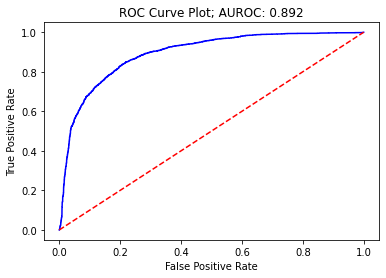

In [54]:
fpr, tpr, _ = roc_curve(y_test, y_hat[:, 1])
plt.plot(fpr, tpr, 'b', label="roc curve")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"NALD Prediction ROC Curve Plot")
plt.show()